In [83]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

In [84]:
chrom = 'X'
ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'
ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'

In [161]:
PAR1X_end = 2699520
PAR2X_start = 154931044

In [85]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [212]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    families = set()
    all_autistic_females = set()
    all_typical_females = set()
    num_autistic_females = defaultdict(int)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    inds = pieces[1:(1+j)]
                        
                    autistic_females = [x for x in inds[2:] if child_id_to_sex[x]=='2' and child_id_to_affected[x]=='2']
                    typical_females = [x for x in inds[2:] if child_id_to_sex[x]=='2' and child_id_to_affected[x]=='1']
                    if len(autistic_females) > 0 or len(typical_females) > 0:
                        families.add(family_key)
                        family_to_individuals[family_key] = inds
                        all_autistic_females.update(autistic_females)
                        all_typical_females.update(typical_females)
                        num_autistic_females[(len(autistic_females), len(typical_females))] += 1

    print('autistic females', len(all_autistic_females))
    print('typical females', len(all_typical_females))
    print('families', len(families))
    print(num_autistic_females)
    return families, all_autistic_females, all_typical_females

ihart_families, ihart_aut_f, ihart_typ_f = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families, ssc_aut_f, ssc_typ_f = load_families(ssc_phase_dir, ssc_family_sizes)



X autistic females 416
typical females 206
families 446
defaultdict(<class 'int'>, {(1, 0): 198, (0, 1): 107, (2, 0): 45, (1, 1): 64, (0, 2): 2, (2, 1): 15, (3, 0): 6, (2, 2): 4, (1, 2): 4, (4, 0): 1})
X autistic females 55
typical females 288
families 312
defaultdict(<class 'int'>, {(1, 0): 24, (0, 1): 257, (1, 1): 31})


In [213]:
# first, load positions
positions = set()
def load_positions(family_sizes, phase_dir, families, aut_f):
    
    for j in family_sizes:
         with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    inds = family_to_individuals[family_key]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                    for i, ind in enumerate(inds[2:]):
                        if ind in aut_f:
                            mat_index = None if state[4+(2*i)] == -1 else state[4+(2*i)]
                            pat_index = None if state[5+(2*i)] == -1 else 2+state[5+(2*i)]
                            #if (mat_index is not None and state[mat_index]==0) or \
                            #(pat_index is not None and state[pat_index]==0):
                            positions.add(start_pos-1)
                            positions.add(start_pos)
                            positions.add(end_pos)
                            positions.add(end_pos+1)
                                
load_positions(ihart_family_sizes, ihart_phase_dir, ihart_families, ihart_aut_f)
load_positions(ssc_family_sizes, ssc_phase_dir, ssc_families, ssc_aut_f)
load_positions(ihart_family_sizes, ihart_phase_dir, ihart_families, ihart_typ_f)
load_positions(ssc_family_sizes, ssc_phase_dir, ssc_families, ssc_typ_f)

positions = np.array(sorted(positions))
position_to_index = dict([(x, i) for i, x in enumerate(positions)])

print('positions', len(positions))


positions 457251


In [214]:
ihart_aut_f = sorted(ihart_aut_f)
ssc_aut_f = sorted(ssc_aut_f)
ihart_typ_f = sorted(ihart_typ_f)
ssc_typ_f = sorted(ssc_typ_f)

In [254]:
from collections import defaultdict

def load_deletions(family_sizes, phase_dir, families, aut_f, typ_f):
    # maternal then paternal
    # position, mat/pat, typ/aut, nodel/del
    deletions = np.zeros((len(positions), 2, 2, 2), dtype=int)
    
    # position, b/c
    sdt_deletions = np.zeros((len(positions), 2), dtype=np.int8)
    
    for j in family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    inds = family_to_individuals[family_key]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    start_index = position_to_index[start_pos]
                    end_index = position_to_index[end_pos+1]
                        
                    if child_id_to_sex[inds[2]] == '2':
                        # first child is female, so p1==X and p2==Y
                        pat_y_index = 3
                    elif child_id_to_sex[inds[2]] == '1':
                        # first child is male, so p2==X and p1==Y
                        pat_y_index = 2
                    else:
                        raise Exception('sex of all children must be known')
                        
                    in_par = start_pos <= PAR1X_end or end_pos >= PAR2X_start
                    
                    if (in_par or state[pat_y_index] == 0) and state[-1]!=1:
                        c_a, c_u, n_a, n_u = 0, 0, 0, 0
                        for i, ind in enumerate(inds[2:]):
                            if ind in aut_f or ind in typ_f:
                                mat_index = None if state[4+(2*i)] == -1 else state[4+(2*i)]
                                pat_index = None if state[5+(2*i)] == -1 else 2+state[5+(2*i)]

                                if mat_index is not None and state[mat_index] != -1:
                                    deletions[start_index:end_index, 0, int(ind in aut_f), 1-state[mat_index]] += 1 

                                if pat_index is not None and state[pat_index]  != -1:
                                    deletions[start_index:end_index, 1, int(ind in aut_f), 1-state[pat_index] ] += 1
                                    if ind in aut_f:
                                        n_a += 1
                                        if state[pat_index] == 0:
                                            c_a += 1
                                    else:
                                        n_u += 1
                                        if state[pat_index] == 0:
                                            c_u += 1
                        if n_a > 0 and n_u > 0:
                            m_a = c_a/n_a
                            m_u = c_u/n_u
                            if m_a > m_u:
                                sdt_deletions[start_index:end_index, 0] += 1
                            elif m_a < m_u:
                                sdt_deletions[start_index:end_index, 1] += 1
    return deletions, sdt_deletions

ihart_deletions, ihart_sdt_deletions = load_deletions(ihart_family_sizes, ihart_phase_dir, ihart_families, ihart_aut_f, ihart_typ_f)
ssc_deletions, ssc_sdt_deletions = load_deletions(ssc_family_sizes, ssc_phase_dir, ssc_families, ssc_aut_f, ssc_typ_f)


# Try SDT

In [255]:
cached_pvalue = dict()
def calc_pvalue_binom(b, c):
    k = (b, c)
    if k not in cached_pvalue:
        cached_pvalue[k] = 2*min(scipy.stats.binom.cdf(b, b+c, 0.5), scipy.stats.binom.cdf(c, b+c, 0.5))
    return cached_pvalue[k]

In [256]:
# position, mat/pat, typ/aut, nodel/del
def sdt_test_f_pat(sdt_deletions):
    # sibling disequilibrium test
    num_tests = 0
    pvalues = np.ones((sdt_deletions.shape[0],))
    for j in range(sdt_deletions.shape[0]):
        if np.sum(sdt_deletions[j, :]) != 0:
            pvalues[j] = calc_pvalue_binom(sdt_deletions[j, 0], sdt_deletions[j, 1])
            if j==0 or np.any(sdt_deletions[j, :] != sdt_deletions[j-1, :]):
                num_tests += 1
    return pvalues, num_tests

ihart_sdt_pvalues, ihart_sdt_num_tests = sdt_test_f_pat(ihart_sdt_deletions)
ssc_sdt_pvalues, ssc_sdt_num_tests = sdt_test_f_pat(ssc_sdt_deletions)
both_sdt_pvalues, both_sdt_num_tests = sdt_test_f_pat(ihart_sdt_deletions + ssc_sdt_deletions)

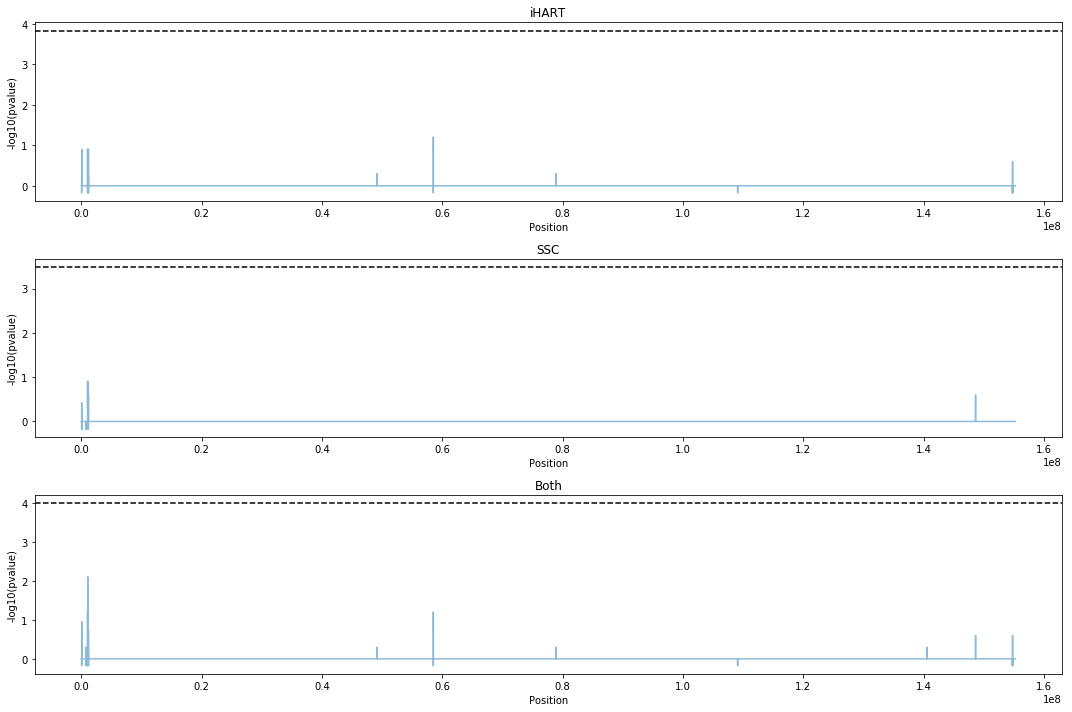

In [257]:
plt.figure(figsize=(15, 10))
  
plt.subplot(3, 1, 1)
plt.plot(positions, -np.log10(ihart_sdt_pvalues), alpha=0.5)
plt.axhline(-np.log10(0.05/ihart_sdt_num_tests), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART')

plt.subplot(3, 1, 2)
plt.plot(positions, -np.log10(ssc_sdt_pvalues), alpha=0.5)
plt.axhline(-np.log10(0.05/ssc_sdt_num_tests), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('SSC')

plt.subplot(3, 1, 3)
plt.plot(positions, -np.log10(both_sdt_pvalues), alpha=0.5)
plt.axhline(-np.log10(0.05/both_sdt_num_tests), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Both')

plt.tight_layout()
plt.show()

# Try mat vs pat deletion discrepancy

In [258]:
def calc_hypergeometric_pvalue(ct):
    aut_trans, typ_trans, aut_notrans, typ_notrans = ct[1, 1], ct[0, 1], ct[1, 0], ct[0, 0]
    trans_op = typ_trans + aut_trans + aut_notrans + typ_notrans
    trans = typ_trans + aut_trans
    
    if aut_trans/(aut_trans+aut_notrans) > typ_trans/(typ_trans+typ_notrans):
        return min(1, 2*scipy.stats.hypergeom.sf(aut_trans, trans_op, aut_trans+aut_notrans, trans) + scipy.stats.hypergeom.pmf(aut_trans, trans_op, aut_trans+aut_notrans, trans))
    else:
        return min(1, 2*scipy.stats.hypergeom.cdf(aut_trans, trans_op, aut_trans+aut_notrans, trans))

cached_pvalue = dict()
def calc_pvalue_contingency(ct):
    k = tuple(ct.ravel())
    if k not in cached_pvalue:
        if np.all(ct>5):
            cached_pvalue[k] = scipy.stats.chi2_contingency(ct)[1]
        else:
            cached_pvalue[k] = calc_hypergeometric_pvalue(ct)
    return cached_pvalue[k]

In [340]:
def calc_pvalues(deletions):
    print(deletions.shape)
    num_tests = 0
    pvalues = np.ones((deletions.shape[0],))
    for j in range(deletions.shape[0]):
        if np.sum(deletions[j, :, :]) != 0:
            pvalues[j] = calc_pvalue(deletions[j, :, :])
            if j==0 or np.any(deletions[j, :, :] != deletions[j-1, :, :]):
                num_tests += 1
                
    logpvalues = -np.log10(pvalues)
    indices = deletions[:, 1, 1]/np.sum(deletions[:, 1, :], axis=1) > deletions[:, 0, 1]/np.sum(deletions[:, 0, :], axis=1)
    logpvalues[indices] = -logpvalues[indices]

    return pvalues, logpvalues, num_tests

both_deletions = ihart_deletions + ssc_deletions

# position, mat/pat, typ/aut, nodel/del
pvalues_ihart_aut, logpvalues_ihart_aut, numtests_ihart_aut = calc_pvalues(ihart_deletions[:, :, 1, :])
pvalues_ssc_aut, logpvalues_ssc_aut, numtests_ssc_aut = calc_pvalues(ssc_deletions[:, :, 1, :])
pvalues_both_aut, logpvalues_both_aut, numtests_both_aut = calc_pvalues(both_deletions[:, :, 1, :])

pvalues_ihart_typ, logpvalues_ihart_typ, numtests_ihart_typ = calc_pvalues(ihart_deletions[:, :, 0, :])
pvalues_ssc_typ, logpvalues_ssc_typ, numtests_ssc_typ = calc_pvalues(ssc_deletions[:, :, 0, :])
pvalues_both_typ, logpvalues_both_typ, numtests_both_typ = calc_pvalues(both_deletions[:, :, 0, :])

pvalues_ihart_mat, logpvalues_ihart_mat, numtests_ihart_mat = calc_pvalues(ihart_deletions[:, 0, :, :])
pvalues_ssc_mat, logpvalues_ssc_mat, numtests_ssc_mat = calc_pvalues(ssc_deletions[:, 0, :, :])
pvalues_both_mat, logpvalues_both_mat, numtests_both_mat = calc_pvalues(both_deletions[:, 0, :, :])

pvalues_ihart_pat, logpvalues_ihart_pat, numtests_ihart_pat = calc_pvalues(ihart_deletions[:, 1, :, :])
pvalues_ssc_pat, logpvalues_ssc_pat, numtests_ssc_pat = calc_pvalues(ssc_deletions[:, 1, :, :])
pvalues_both_pat, logpvalues_both_pat, numtests_both_pat = calc_pvalues(both_deletions[:, 1, :, :])

(457251, 2, 2)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)
(457251, 2, 2)


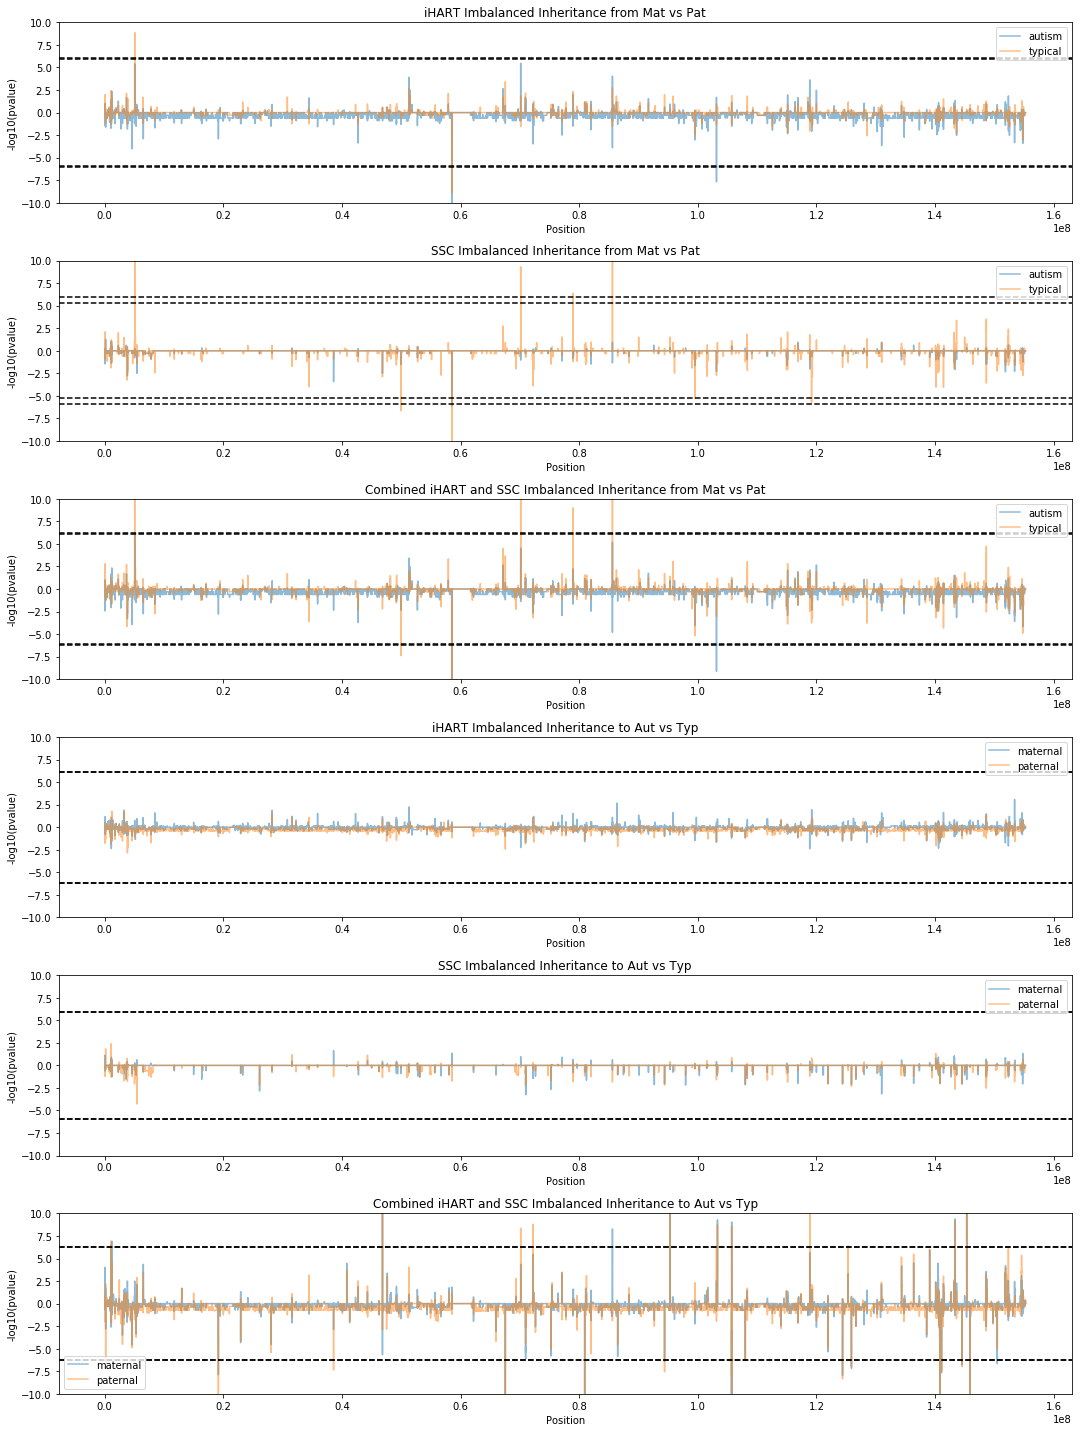

In [343]:
plt.figure(figsize=(15, 20))
  
plt.subplot(6, 1, 1)
plt.plot(positions, logpvalues_ihart_aut, alpha=0.5, label='autism')
plt.plot(positions, logpvalues_ihart_typ, alpha=0.5, label='typical')
plt.axhline(-np.log10(0.05/numtests_ihart_aut), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_aut), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_typ), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_typ), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART Imbalanced Inheritance from Mat vs Pat')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(positions, logpvalues_ssc_aut, alpha=0.5, label='autism')
plt.plot(positions, logpvalues_ssc_typ, alpha=0.5, label='typical')
plt.axhline(-np.log10(0.05/numtests_ssc_aut), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_aut), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_typ), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_typ), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('SSC Imbalanced Inheritance from Mat vs Pat')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(positions, logpvalues_both_aut, alpha=0.5, label='autism')
plt.plot(positions, logpvalues_both_typ, alpha=0.5, label='typical')
plt.axhline(-np.log10(0.05/numtests_both_aut), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_aut), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_both_typ), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_typ), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Combined iHART and SSC Imbalanced Inheritance from Mat vs Pat')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(positions, logpvalues_ihart_mat, alpha=0.5, label='maternal')
plt.plot(positions, logpvalues_ihart_pat, alpha=0.5, label='paternal')
plt.axhline(-np.log10(0.05/numtests_ihart_mat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_mat), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_pat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_pat), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART Imbalanced Inheritance to Aut vs Typ')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(positions, logpvalues_ssc_mat, alpha=0.5, label='maternal')
plt.plot(positions, logpvalues_ssc_pat, alpha=0.5, label='paternal')
plt.axhline(-np.log10(0.05/numtests_ssc_mat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_mat), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_pat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_pat), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('SSC Imbalanced Inheritance to Aut vs Typ')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(positions, logpvalues_both_mat, alpha=0.5, label='maternal')
plt.plot(positions, logpvalues_both_pat, alpha=0.5, label='paternal')
plt.axhline(-np.log10(0.05/numtests_both_mat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_mat), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_both_pat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_pat), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Combined iHART and SSC Imbalanced Inheritance to Aut vs Typ')
plt.ylim([-10, 10])
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 1080x720 with 0 Axes>

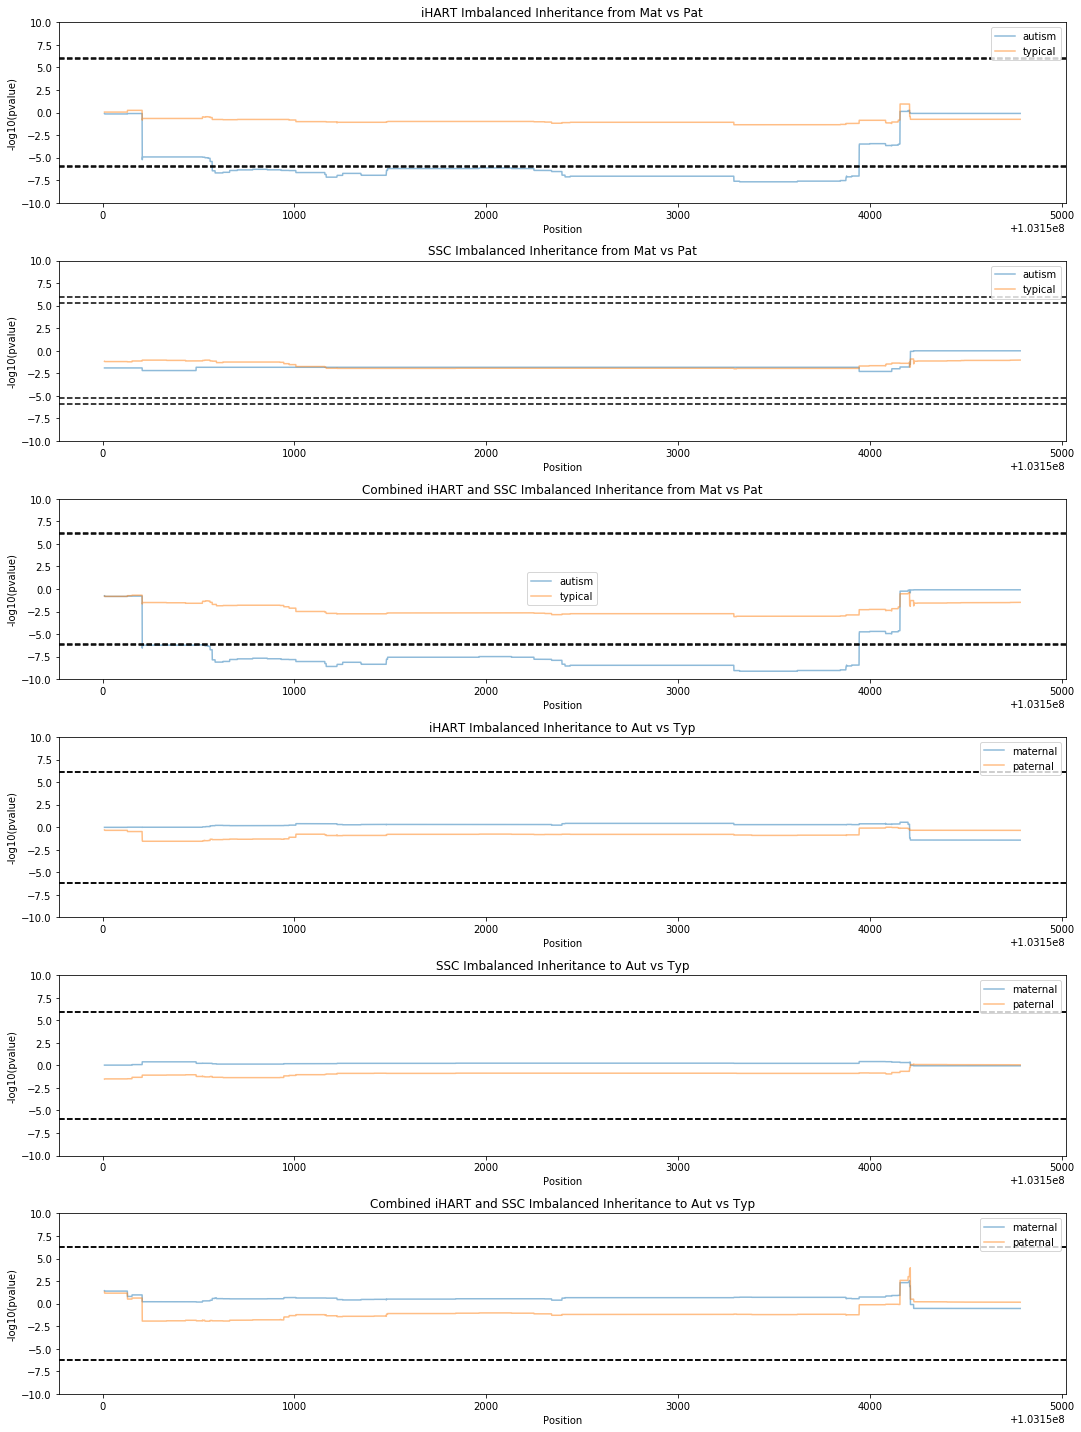

In [349]:
plt.figure(figsize=(15, 10))

#start, end = 5055345, 5057501
#start, end = 58506835, 58527574
#start, end = 70135851, 70141159
start, end = 103150000, 103155000

indices = (positions>=start) & (positions<=end)

plt.figure(figsize=(15, 20))
  
plt.subplot(6, 1, 1)
plt.plot(positions[indices], logpvalues_ihart_aut[indices], alpha=0.5, label='autism')
plt.plot(positions[indices], logpvalues_ihart_typ[indices], alpha=0.5, label='typical')
plt.axhline(-np.log10(0.05/numtests_ihart_aut), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_aut), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_typ), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_typ), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART Imbalanced Inheritance from Mat vs Pat')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(positions[indices], logpvalues_ssc_aut[indices], alpha=0.5, label='autism')
plt.plot(positions[indices], logpvalues_ssc_typ[indices], alpha=0.5, label='typical')
plt.axhline(-np.log10(0.05/numtests_ssc_aut), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_aut), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_typ), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_typ), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('SSC Imbalanced Inheritance from Mat vs Pat')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(positions[indices], logpvalues_both_aut[indices], alpha=0.5, label='autism')
plt.plot(positions[indices], logpvalues_both_typ[indices], alpha=0.5, label='typical')
plt.axhline(-np.log10(0.05/numtests_both_aut), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_aut), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_both_typ), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_typ), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Combined iHART and SSC Imbalanced Inheritance from Mat vs Pat')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(positions[indices], logpvalues_ihart_mat[indices], alpha=0.5, label='maternal')
plt.plot(positions[indices], logpvalues_ihart_pat[indices], alpha=0.5, label='paternal')
plt.axhline(-np.log10(0.05/numtests_ihart_mat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_mat), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_pat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ihart_pat), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('iHART Imbalanced Inheritance to Aut vs Typ')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(positions[indices], logpvalues_ssc_mat[indices], alpha=0.5, label='maternal')
plt.plot(positions[indices], logpvalues_ssc_pat[indices], alpha=0.5, label='paternal')
plt.axhline(-np.log10(0.05/numtests_ssc_mat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_mat), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_pat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_ssc_pat), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('SSC Imbalanced Inheritance to Aut vs Typ')
plt.ylim([-10, 10])
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(positions[indices], logpvalues_both_mat[indices], alpha=0.5, label='maternal')
plt.plot(positions[indices], logpvalues_both_pat[indices], alpha=0.5, label='paternal')
plt.axhline(-np.log10(0.05/numtests_both_mat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_mat), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_both_pat), linestyle='--', color='black')
plt.axhline(np.log10(0.05/numtests_both_pat), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Combined iHART and SSC Imbalanced Inheritance to Aut vs Typ')
plt.ylim([-10, 10])
plt.legend()

plt.tight_layout()
plt.show()

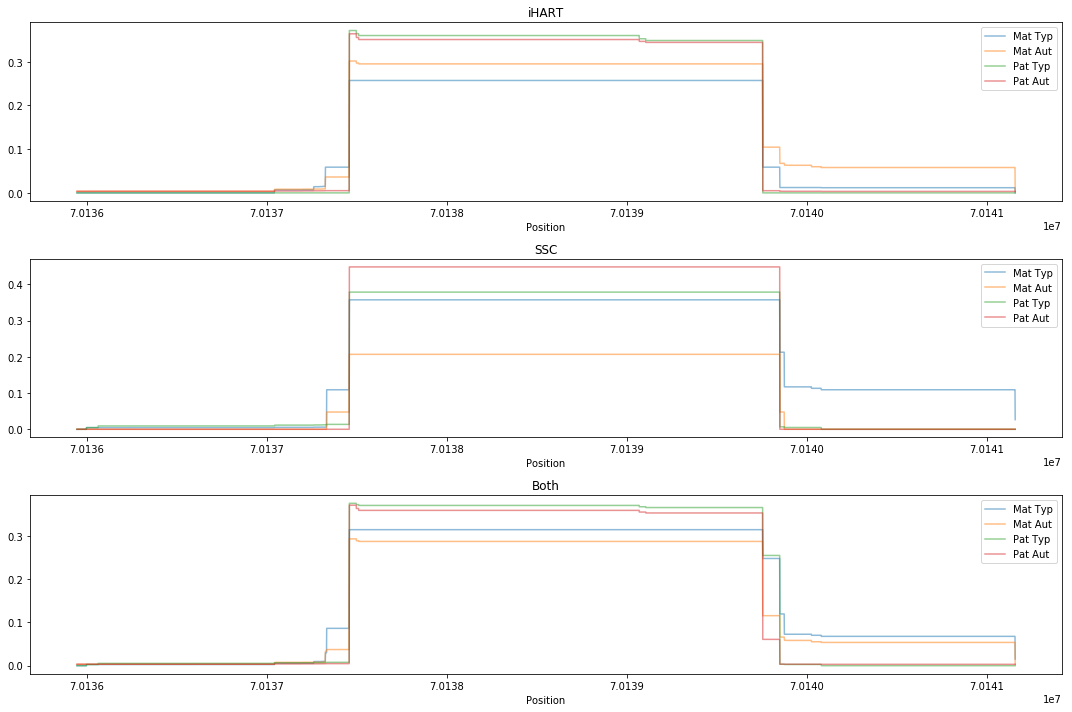

In [294]:
plt.figure(figsize=(15, 10))
# position, mat/pat, typ/aut, nodel/del

plt.subplot(3, 1, 1)
plt.plot(positions[indices], ihart_deletions[indices, 0, 0, 1]/np.sum(ihart_deletions[indices, 0, 0, :], axis=1), 
         alpha=0.5, label='Mat Typ')
plt.plot(positions[indices], ihart_deletions[indices, 0, 1, 1]/np.sum(ihart_deletions[indices, 0, 1, :], axis=1), 
         alpha=0.5, label='Mat Aut')
plt.plot(positions[indices], ihart_deletions[indices, 1, 0, 1]/np.sum(ihart_deletions[indices, 1, 0, :], axis=1), 
         alpha=0.5, label='Pat Typ')
plt.plot(positions[indices], ihart_deletions[indices, 1, 1, 1]/np.sum(ihart_deletions[indices, 1, 1, :], axis=1), 
         alpha=0.5, label='Pat Aut')
plt.legend()
plt.title('iHART')
plt.xlabel('Position')

plt.subplot(3, 1, 2)
plt.plot(positions[indices], ssc_deletions[indices, 0, 0, 1]/np.sum(ssc_deletions[indices, 0, 0, :], axis=1), 
         alpha=0.5, label='Mat Typ')
plt.plot(positions[indices], ssc_deletions[indices, 0, 1, 1]/np.sum(ssc_deletions[indices, 0, 1, :], axis=1), 
         alpha=0.5, label='Mat Aut')
plt.plot(positions[indices], ssc_deletions[indices, 1, 0, 1]/np.sum(ssc_deletions[indices, 1, 0, :], axis=1), 
         alpha=0.5, label='Pat Typ')
plt.plot(positions[indices], ssc_deletions[indices, 1, 1, 1]/np.sum(ssc_deletions[indices, 1, 1, :], axis=1), 
         alpha=0.5, label='Pat Aut')
plt.legend()
plt.title('SSC')
plt.xlabel('Position')

both_deletions = ihart_deletions+ssc_deletions

plt.subplot(3, 1, 3)
plt.plot(positions[indices], both_deletions[indices, 0, 0, 1]/np.sum(both_deletions[indices, 0, 0, :], axis=1), 
         alpha=0.5, label='Mat Typ')
plt.plot(positions[indices], both_deletions[indices, 0, 1, 1]/np.sum(both_deletions[indices, 0, 1, :], axis=1), 
         alpha=0.5, label='Mat Aut')
plt.plot(positions[indices], both_deletions[indices, 1, 0, 1]/np.sum(both_deletions[indices, 1, 0, :], axis=1), 
         alpha=0.5, label='Pat Typ')
plt.plot(positions[indices], both_deletions[indices, 1, 1, 1]/np.sum(both_deletions[indices, 1, 1, :], axis=1), 
         alpha=0.5, label='Pat Aut')
plt.legend()
plt.title('Both')
plt.xlabel('Position')

plt.tight_layout()
plt.show()